In [1]:
from sympy import *
from sympy.functions.special.beta_functions import beta, betainc
from sympy import lambdify
from scipy.integrate import quad
from sympy import lambdify
from scipy.integrate import quad
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets

#from sympy.stats import Beta, density, E, variance

In [2]:
#define distribution of individual types
mu = symbols('mu', real = True, positive = True) #mean probability of beliefs (real probability)
p = symbols('p', real = True, positive = True) #price of yes bet
r = symbols('r', real = True, positive = True) #interest rate
t = symbols('t', real = True, positive = True) #time until resolution
#type is drawn from the distribution
theta = symbols('theta', real = True, positive =True) #type of individual, drawn from type_dist
a = symbols('a', real = True, positive = True) #parameters of beta distribution
b = symbols('b', real = True, positive = True) #parameters of beta distribution

#don't forget to bind between 0 and 1 when integrating!!!!
'''beta = Piecewise(
    #(0, theta < 0),
    #(0, theta > 1),
    (theta**(a-1)*(1-theta)**(b-1)/(gamma(a)*gamma(b)/gamma(a+b)), True)
)'''
#beta = theta**(a-1)*(1-theta)**(b-1)/(gamma(a)*gamma(b)/gamma(a+b))
#be = beta(a, b)
#beta = Beta('beta', a, b)

#calculate a and b based on mu and standard deviation
s = symbols('s') #standard deviation arbitrarly chosen
n = mu*(1-mu)/s**2
a = mu*n
b = (1-mu)*n

#population density based on theta
f = Function('f')(theta)


return_yes = ((1)*theta+(0)*(1-theta))/p #expected return of yes bet
return_no = ((1)*(1-theta)-(0)*(theta))/(1-p) #expected return of no bet
outside_return = (1+r)**t #return of outside option
'''
#optimal bet given type
def bet(theta,p):
    return_yes = ((theta-p)/(1+r)**t)
    return_no = ((1-theta)-(1-p))/(1+r)**t
    return Piecewise(
        (1, return_yes>0),
        (0, (return_yes<=0)&(return_no<=0)),
        (-1, return_no>0))
'''

#As a kelly criterion bet
bet = Piecewise(
    (theta - (1-theta)/(return_yes), theta - (1-theta)/(return_yes)>=0),
    (-((1-theta)-(theta)/(return_no)), (1-theta)-(theta)/(return_no)>0),
    (0, True))

#kelly criterion with discounted future return
bet_discounted = Piecewise(
    (theta - (1-theta)/(return_yes/outside_return), theta - (1-theta)/(return_yes/outside_return)>=0),
    (-((1-theta)-(theta)/(return_no/outside_return)), (1-theta)-(theta)/(return_no/outside_return)>0),
    (0, True))

def beta_pdf (x):
    return (x**(a-1)*(1-x)**(b-1))/(factorial(a-1)*factorial(b-1)/factorial(a+b-1))

#market clearing condition
#as a piecewise integration
market_clear = Integral(f*bet, (theta,0,1))

market_clear_discounted = Integral(f*bet_discounted, (theta,0,1))


#number of yes bets given price
#lowest type yes bet
yes_p_min = solve(Eq(return_yes, outside_return), theta)[0]
#highest type no bet
no_p_max = solve(Eq(return_no, outside_return), theta)[0]




#number of yes bets equals number of no bets
number_yes = Piecewise(
    (0,yes_p_min >= 1),
    (integrate(f, (theta, yes_p_min, 1)), True)
)
#number_yes = betainc(a, b, yes_p_min, 1)
number_no = Piecewise(
    (0, no_p_max<=0),
    (integrate(f, (theta, 0, no_p_max)), True)
)
#number_no = betainc(a,b, 0, no_p_max)
market2 = number_yes - number_no
market_clear2 = Eq(market2, 0)

market_clear2

Eq(Piecewise((0, p*(r + 1)**t >= 1), (Integral(f(theta), (theta, p*(r + 1)**t, 1)), True)) - Piecewise((0, p*(r + 1)**t - (r + 1)**t <= -1), (Integral(f(theta), (theta, 0, p*(r + 1)**t - (r + 1)**t + 1)), True)), 0)

# Model Explanation
This project mathematically models the assumptions around prediction markets. It tests 2 models for predition markets and how equilibrium prices differ from the "true" probability of events occuring when agents face outside options. Both models asusme that market participants have a belief $\theta \in (0,1)$ about the outcome of the market, and that the distribution of these beliefs amongst the population follows some probability distribution $f(\theta)$. (This distribution is equally interpretable as distribution of funds, the principle remains the same). I model $f(\theta)$ as beta function with shape parameters $(\alpha, \beta)$ defined to center the function around a "true probability" $\mu$ and a standard deviation $s$.

These market participants have identical outside option, which with certainty can multiply their money by rate $(1+r)^t$ where $r$ is the interest rate and $t$ is the number of periods until the bet is expected to be resolved.

This is expected to discourage market participants that have more accurate knowledge of future events when prices are accurate to the true probability. This expectation is consistent with the unusual distribution seen in polymarket order books, in which there are few orders around the price, and then a large increase in unfilled orders at a specific cutoff point on both sides of the price, after which unfilled orders rise in both directions.

## Model 1: True risk neutrality

Under the true rist neutraility, market participants are trying to maximise their expected return as a function of price $p$ and will bet if and only if the expected percentage return exceeds the  outside option $(1+r)^t$. A market participant of type $\theta$ expects a return of $\frac{\theta}{p}$ for a yes bet, and $\frac{(1 - \theta)}{(1 - p)}$ for a no bet, where $p \in (0,1)$ is the price of a yes bet. Thus participants bet yes if $\frac{\theta}{p}>(1+r)^t$ and no if $\frac{(1 - \theta)}{(1 - p)}>(1+r)^t$ and does not place a bet otherwise.

Thus the maximum type $\theta$ that will take a no bet given price $p$ is:

In [3]:
no_p_max

p*(r + 1)**t - (r + 1)**t + 1

And the minimum type $\theta$ that will take a yes bet is:

In [4]:
yes_p_min

p*(r + 1)**t

The number of yes and no bets are thus defined as:

In [5]:
number_yes

Piecewise((0, p*(r + 1)**t >= 1), (Integral(f(theta), (theta, p*(r + 1)**t, 1)), True))

In [6]:
number_no

Piecewise((0, p*(r + 1)**t - (r + 1)**t <= -1), (Integral(f(theta), (theta, 0, p*(r + 1)**t - (r + 1)**t + 1)), True))

And the market clearing price is listed below, both in generic form, and for the specific distribution:

In [7]:
market_clear2

Eq(Piecewise((0, p*(r + 1)**t >= 1), (Integral(f(theta), (theta, p*(r + 1)**t, 1)), True)) - Piecewise((0, p*(r + 1)**t - (r + 1)**t <= -1), (Integral(f(theta), (theta, 0, p*(r + 1)**t - (r + 1)**t + 1)), True)), 0)

In [8]:
market_clear2.subs(f, beta_pdf(theta))

Eq(Piecewise((0, p*(r + 1)**t >= 1), (Integral(theta**(mu**2*(1 - mu)/s**2 - 1)*(1 - theta)**(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 + mu*(1 - mu)**2/s**2 - 1)/(factorial(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 - 1)), (theta, p*(r + 1)**t, 1)), True)) - Piecewise((0, p*(r + 1)**t - (r + 1)**t <= -1), (Integral(theta**(mu**2*(1 - mu)/s**2 - 1)*(1 - theta)**(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 + mu*(1 - mu)**2/s**2 - 1)/(factorial(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 - 1)), (theta, 0, p*(r + 1)**t - (r + 1)**t + 1)), True)), 0)

We are interested in how biased true probability $\mu$ differs from the prices given under this model. These pricing conditions are not solvable analytically, thus we computationally derive the curve for market clearing conditions below. Below is an interactive graph that allows you to test how changes in $r$ $t$ and $s$ change the bias across possible $\mu$. Notice how as $(1+r)^t$ becomes larger, the bias tends towards having an equilibrium price closer to 0.5 than the true probability. Additionally, increasing s tends to make the line straighter.

(TODO: Have a single non interactive graph showing curves as $(1+r)^t$ increases as different colored lines)

In [9]:
r_widg = widgets.FloatSlider(
    value=0.03,
    min=0,
    max=1.0,
    step=0.01,
    description='r:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
t_widg = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Time periods t:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
mu_widg = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='mean mu:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
p_widg = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='p:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
s_widg = widgets.FloatSlider(
    value=0.145,
    min=0,
    max=0.5,
    step=0.001,
    description='s:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
def graph(a,b,c,d,e):
    cond = {mu:a, r:b, t:c, p:d, s:e}
    p1 = plot(beta_pdf(theta).subs(cond), (theta, 0, 1), show=False, n = 100, adaptive = False)
    p1.extend(plot(bet.subs(cond), (theta, 0, 1), show=False))
    p1.extend(plot(bet_discounted.subs(cond), (theta, 0, 1), show=False))
    p1.extend(plot(return_yes.subs(cond), (theta, 0, 1), show=False))
    p1.extend(plot(return_no.subs(cond), (theta, 0, 1), show=False))
    p1.show()

widgets.interact(graph, a = mu_widg, b = r_widg, c = t_widg, d = p_widg, e = s_widg)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='mean mu:', max=1.0, step=0.…

<function __main__.graph(a, b, c, d, e)>

In [10]:
r_widg2 = widgets.FloatSlider(
    value=0.3,
    min=0,
    max=1.0,
    step=0.01,
    description='r:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
t_widg2 = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Time periods t:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
mu_widg2 = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='mean mu:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
s_widg2 = widgets.FloatSlider(
    value=0.145,
    min=0,
    max=0.5,
    step=0.001,
    description='s:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
#function g allows us to find the price that clears the market for a given mean in our distribution
def g(x,cond):
    try:
        ret = nsolve((number_yes-number_no).subs(cond).subs(mu,x),(0,1), solver='bisect')
    except ValueError:
        ret = None
    return ret



xvals = np.linspace(0.0001,0.9999,10) #10 points

def make_plot(r_w,t_w,s_w):
    cond = {f:beta_pdf(theta), r:r_w, t:t_w, s:s_w}
    yvals = [] #empty list
    for i in range(len(xvals)):
        yvals.append(g(xvals[i],cond)) #evaluate f for each point in xvals
    #vals = list(map(g, xvals)) #evaluate f for each point in xvals 
    plt.plot(xvals, yvals)
    plt.plot(xvals, xvals, color = 'red', linestyle = '--')
    plt.xlabel('True probability (mu)')
    plt.ylabel('Equilibrium price of yes bet')


display(widgets.interact(make_plot,r_w = r_widg2, t_w = t_widg2, s_w = s_widg2))


interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='r:', max=1.0, step=0.01), I…

<function __main__.make_plot(r_w, t_w, s_w)>

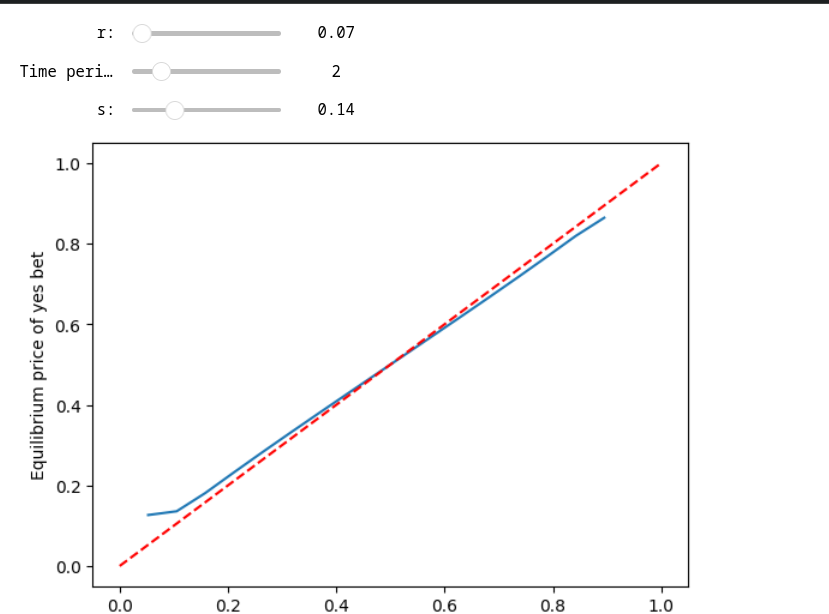

** note that above if you have made $(1+r)^t$ so large that no one will take any bets the line flattens out. This obviously is not the true curve, just a mathematical consequence of no one betting. Additionally only 10 points are plotted to increase the speedy responsiveness. **

## Model 2: Risk aversion

In model 2 we add an additional assumption, which is that market participants are risk averse. While in the first scenario we assumed that every participant, regardless of type staked their entire endowment into the market (or that each person places a single bet), we now assume that participants are risk averse, and less confident investors stake a smaller share of their endowment. To fulfil this assumption we assume that participants follow kelly's formula, with discounted future returns. 

In [11]:
(theta - (1-theta)/(return_yes/outside_return)) #kelly criterion with discounted future return

-p*(1 - theta)*(r + 1)**t/theta + theta

Kelly criterion maximizes log discounted returns for a user of type $\theta$ given a price $p$. Notice that while a higher fraction of money in the market is centered around the true probability, these market participants are more cautious, as they expect a lower average return. The blue line is the beta distribution of types, the orange line represents optimal bets (negative values are 'no' bets), and the green line is the distribution given that participants take into account discounted future value.

In [12]:
r_widg = widgets.FloatSlider(
    value=0.03,
    min=0,
    max=1.0,
    step=0.01,
    description='r:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
t_widg = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Time periods t:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
mu_widg = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='mean mu:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
p_widg = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='p:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
s_widg = widgets.FloatSlider(
    value=0.145,
    min=0,
    max=0.5,
    step=0.001,
    description='s:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
def graph(a,b,c,d,e):
    cond = {mu:a, r:b, t:c, p:d, s:e}
    p1 = plot(beta_pdf(theta).subs(cond), (theta, 0, 1), show=False, n = 100, adaptive = False)
    p1.extend(plot(bet.subs(cond), (theta, 0, 1), show=False))
    p1.extend(plot(bet_discounted.subs(cond), (theta, 0, 1), show=False))
    #p1.extend(plot(return_yes.subs(cond), (theta, 0, 1), show=False))
    #p1.extend(plot(return_no.subs(cond), (theta, 0, 1), show=False))
    p1.show()

widgets.interact(graph, a = mu_widg, b = r_widg, c = t_widg, d = p_widg, e = s_widg)


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='mean mu:', max=1.0, step=0.…

<function __main__.graph(a, b, c, d, e)>

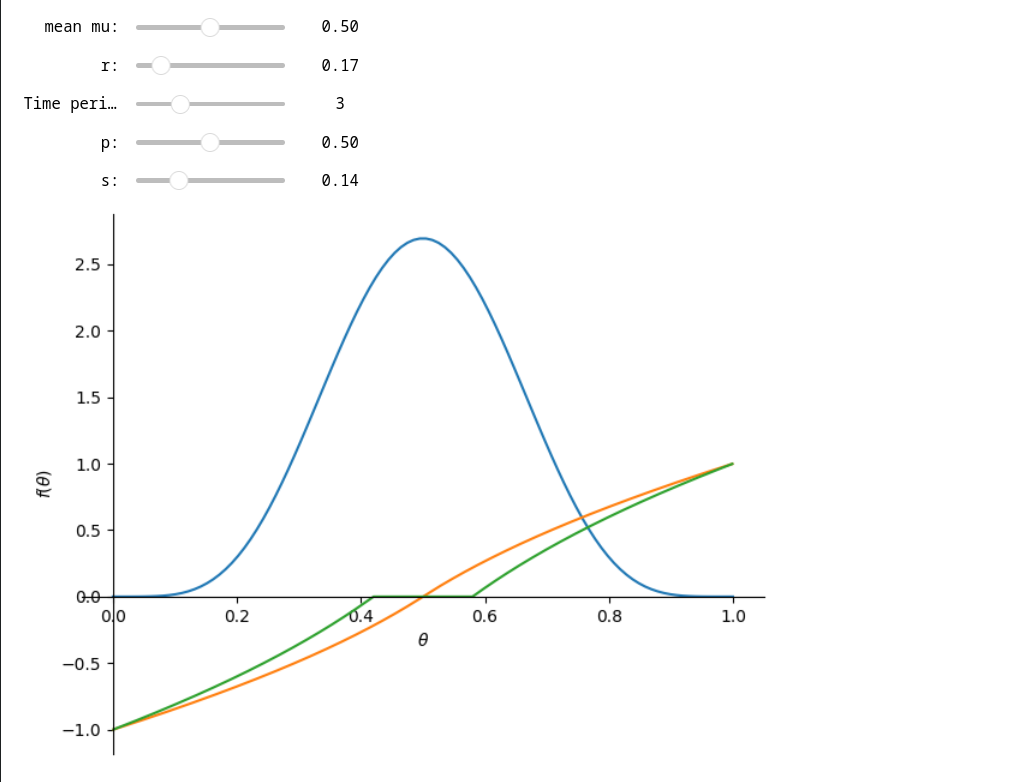

The market clearing conditions are thus represented below, both generically, and given a specified beta distribution.

In [13]:
market_clear

Integral(Piecewise(((-p*(1 - theta)/theta + theta)*f(theta), p*(1 - theta)/theta - theta <= 0), ((theta*(1 - p)/(1 - theta) + theta - 1)*f(theta), theta*(1 - p)/(1 - theta) + theta < 1), (0, True)), (theta, 0, 1))

In [14]:
market_clear.subs(f, beta_pdf(theta))

Integral(Piecewise((theta**(mu**2*(1 - mu)/s**2 - 1)*(1 - theta)**(mu*(1 - mu)**2/s**2 - 1)*(-p*(1 - theta)/theta + theta)*factorial(mu**2*(1 - mu)/s**2 + mu*(1 - mu)**2/s**2 - 1)/(factorial(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 - 1)), p*(1 - theta)/theta - theta <= 0), (theta**(mu**2*(1 - mu)/s**2 - 1)*(1 - theta)**(mu*(1 - mu)**2/s**2 - 1)*(theta*(1 - p)/(1 - theta) + theta - 1)*factorial(mu**2*(1 - mu)/s**2 + mu*(1 - mu)**2/s**2 - 1)/(factorial(mu*(1 - mu)**2/s**2 - 1)*factorial(mu**2*(1 - mu)/s**2 - 1)), theta*(1 - p)/(1 - theta) + theta < 1), (0, True)), (theta, 0, 1))

Similar as for model 1, the equilibrium price curve given $\mu$ is listed below. Notice that the equilibrium prices exaggerate the true probability of the distribution, given the caution excercised by better informed market actors. 

In [16]:
r_widg3 = widgets.FloatSlider(
    value=0.3,
    min=0,
    max=1.0,
    step=0.01,
    description='r:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
t_widg3 = widgets.IntSlider(
    value=0,
    min=0,
    max=10,
    step=1,
    description='Time periods t:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
mu_widg3 = widgets.FloatSlider(
    value=0.5,
    min=0,
    max=1.0,
    step=0.01,
    description='mean mu:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
s_widg3 = widgets.FloatSlider(
    value=0.145,
    min=0,
    max=0.5,
    step=0.001,
    description='s:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)
#function g allows us to find the price that clears the market for a given mean in our distribution
def g3(x,cond):
    try:
        ret = nsolve((market_clear_discounted).subs(cond).subs(mu,x),(0,1), solver='bisect')
    except ValueError:
        ret = None
    return ret



xvals = np.linspace(0.0001,0.9999, 20) #10 points

def make_plot3(r_w,t_w,s_w):
    cond = {f:beta_pdf(theta), r:r_w, t:t_w, s:s_w}
    yvals = [] #empty list
    for i in range(len(xvals)):
        yvals.append(g3(xvals[i],cond)) #evaluate f for each point in xvals
    #vals = list(map(g, xvals)) #evaluate f for each point in xvals 
    plt.plot(xvals, yvals)
    plt.plot(xvals, xvals, color = 'red', linestyle = '--')
    plt.xlabel('True probability (mu)')
    plt.ylabel('Equilibrium price of yes bet')


display(widgets.interact(make_plot3,r_w = r_widg3, t_w = t_widg3, s_w = s_widg3))


interactive(children=(FloatSlider(value=0.3, continuous_update=False, description='r:', max=1.0, step=0.01), I…

<function __main__.make_plot3(r_w, t_w, s_w)>

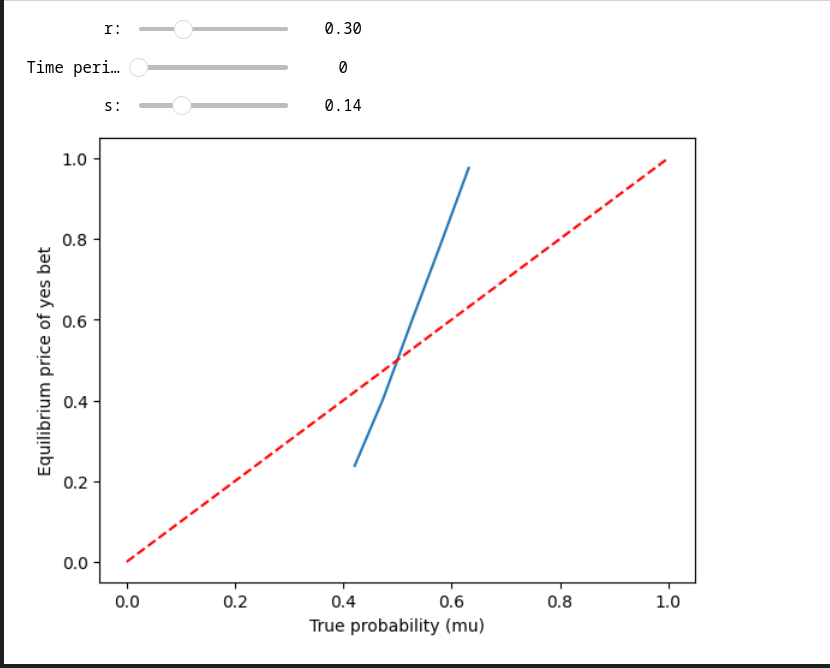

# Conclusion
This paper provides a microfounded model to asses the bias in prices versus the true probability of an event occuring in prediction markets.

This research is important. In the 2024 election many people from political pundits, to equity researchers, to news orginizations, have referenced the odds given on various prediction markets to better understand the true probability of election events. It is vital to understand how outside options and the interest rate bias these markets.

I believe Model 2 is likely the better charachterization of how rational market actors participate in real life. It is more consistent with the unusual distribution seen in polymarket order books, in which there are few orders around the price, and then a large increase in unfilled orders at a specific cutoff point on both sides of the price, after which unfilled orders rise in both directions.

Some important caveats exist however. There is much research on the psychology of gamblers that suggest that a reasonably large share of market actors may be less than risk averse, or even risk loving. Future research should consider markets that contain heterogenous risk preferences accross belief types, and how this affects equilibrium prices.

Additionally, this research provides insight into how prediction markets are affected by the currencies used. There are existing prediction markets that are denominated in crypto-currencies, internal point systems, and in real dollars. The denomination of currencies may affect the interest rate of the outside option. For internal point systems, there are no outside options other than participating in prediction markets, so $(1+r)^t$ is exactly 1. Crypto-currencies may see extreme fluctuation in what $(1+r)^t$ looks like depending on the currency, trend in its particular price, and the slate of reliable investment instruments that exist in this space (I would suspect $(1+r)^t$ to be low, potentially even negative). The outside options in real dollars are relatively well known (t-bills).  This can help explain why odds vary wildly across prediction markets denominated in different currencies, and why arbitrage does not occur.